## Import

In [1]:
import random
import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3090'

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.__version__

'2.0.1+cu118'

In [6]:
# torch.cuda.empty_cache()

## Hyperparameter Setting

In [7]:
CFG = {
    'TRAIN_WINDOW_SIZE':120, # 90일치로 학습  초기는 90일이였음 
    'PREDICT_SIZE':21, # 21일치 예측
    'EPOCHS':100,
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE':4096,
    'SEED':41
}

In [8]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

### 데이터 불러오기

In [9]:
train_data = pd.read_csv('E:/LG/LG_data/train.csv')# .drop(columns = ["ID","제품"])

In [10]:
brand_keyword_cnt = pd.read_csv('E:/LG/LG_data/brand_keyword_cnt.csv')

# EDA

In [11]:
train_data.head(2)

,ID,제품,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,B002-00002-00001,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,0,0,0,1,3,2,0,0,2,0


In [12]:
train_data.isnull().sum()

ID            0
제품            0
대분류           0
중분류           0
소분류           0
             ..
2023-03-31    0
2023-04-01    0
2023-04-02    0
2023-04-03    0
2023-04-04    0
Length: 465, dtype: int64

In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15890 entries, 0 to 15889
Columns: 465 entries, ID to 2023-04-04
dtypes: int64(460), object(5)
memory usage: 56.4+ MB


In [14]:
train_data.describe()

,ID,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
count,15890.000000,15890.000000,15890.000000,15890.00000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,...,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000
mean,7944.500000,12.887476,10.418880,9.01309,9.190938,11.204216,12.486281,12.933103,12.832599,13.326935,...,0.501699,0.483260,0.473694,9.498175,9.370044,7.706293,7.123033,6.975456,9.040340,10.031026
std,4587.192224,183.612376,149.663362,95.82452,86.274138,92.072773,108.478567,135.615709,233.900622,242.761978,...,8.853648,8.911203,8.567765,93.854552,90.632349,68.413621,68.629350,59.826757,73.637191,103.256072
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3972.250000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7944.500000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,11916.750000,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,15889.000000,15056.000000,14320.000000,6064.00000,4470.000000,6370.000000,8210.000000,9712.000000,24512.000000,24032.000000,...,700.000000,660.000000,660.000000,4308.000000,4596.000000,3960.000000,4224.000000,2700.000000,3045.000000,6048.000000


In [15]:
train_data.shape

(15890, 465)

In [16]:
train_data.size

7388850

TypeError: 'value' must be an instance of str or bytes, not a int

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from current font.
  func(*args, **kwargs)
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  func(*args, **kwargs)
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 47448 (\N{HANGUL SYLLABLE RYU}) missing from current font.
  func(*args, **kwargs)
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current

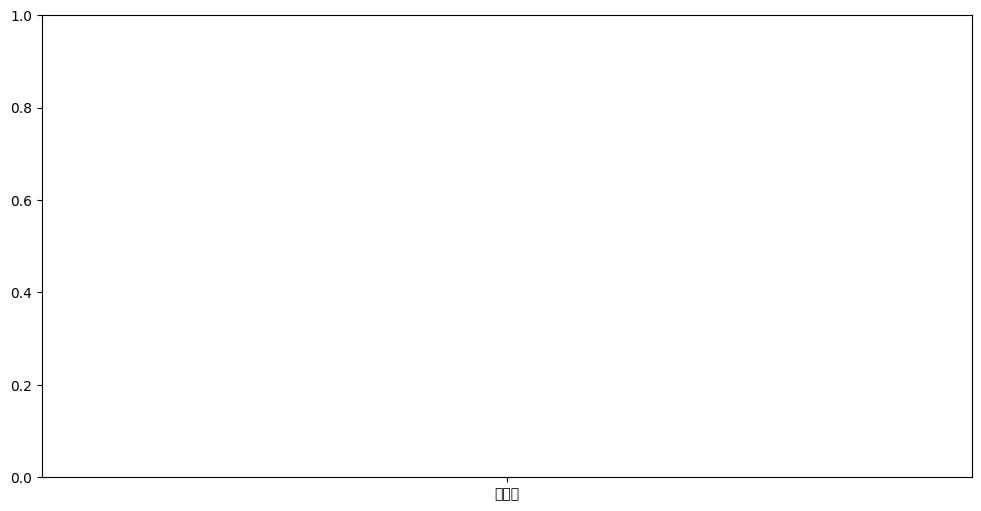

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 불러오기 (예: 데이터프레임 이름을 train_data로 가정)
# train_data = pd.read_csv('데이터 파일 경로.csv')

# 분석할 특정 브랜드명 지정
target_brand = 'B002-00001'  # 분석하려는 브랜드명으로 변경

# 해당 브랜드의 판매량 데이터 추출
brand_sales = train_data[train_data['브랜드'] == target_brand].iloc[:, 4: 50]  # 4번째 열부터 판매량 데이터가 시작됨

# 날짜를 인덱스로 설정 (datetime 형식이 아닌 경우 필요하면 날짜 형식으로 변환)
# brand_sales.columns = pd.to_datetime(brand_sales.columns)

# 판매량 변화 시각화
plt.figure(figsize=(12, 6))
plt.plot(brand_sales.columns, brand_sales.values[0], marker='o', linestyle='-')
plt.title(f'{target_brand} 브랜드의 날짜별 판매량 변화')
plt.xlabel('날짜')
plt.ylabel('판매량')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
brand_sales.head()

,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,2022-01-10,...,2022-02-06,2022-02-07,2022-02-08,2022-02-09,2022-02-10,2022-02-11,2022-02-12,2022-02-13,2022-02-14,2022-02-15
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,0,1,1,1


In [ ]:
brand_sales.values[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1], dtype=int64)

In [ ]:
train_data.columns

Index(['대분류', '중분류', '소분류', '브랜드', '2022-01-01', '2022-01-02', '2022-01-03',
       '2022-01-04', '2022-01-05', '2022-01-06',
       ...
       '2023-03-26', '2023-03-27', '2023-03-28', '2023-03-29', '2023-03-30',
       '2023-03-31', '2023-04-01', '2023-04-02', '2023-04-03', '2023-04-04'],
      dtype='object', length=463)

###  <<<<하고 싶은 EDA>>>>

### 먼저 데이터의 분포를 알고 싶은 그래서 대분류 중분류 소분류의 브랜드을 엮을 생각임 
### ex) 대분류, 브랜등 // 대분류 중분류 브랜드 등등 
### 규칙성이 있다면 규칙성이 있는 것 끼리 묶어서 학습을 시키고 싶음

### ==========================================================================

### <<<교수님께 질문 할 것>>>



In [ ]:
duplicates = train_data[train_data.duplicated('대분류')]
duplicates.shape

(15885, 465)

In [ ]:
duplicates = train_data[train_data.duplicated('대분류', keep=False)]
duplicates.head()

,ID,제품,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,B002-00002-00001,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,0,0,0,1,3,2,0,0,2,0
2,2,B002-00002-00002,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,B002-00002-00003,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,B002-00003-00001,B002-C001-0001,B002-C002-0001,B002-C003-0003,B002-00003,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
대분류_중복_counts = train_data.groupby('대분류').size().reset_index(name='중복 개수')
print(대분류_중복_counts)

              대분류  중복 개수
0  B002-C001-0001   3768
1  B002-C001-0002  10954
2  B002-C001-0003    444
3  B002-C001-0004    111
4  B002-C001-0005    613


In [ ]:
중분류_중복_counts = train_data.groupby('중분류').size().reset_index(name='중복 개수')
print(중분류_중복_counts)

               중분류  중복 개수
0   B002-C002-0001   3608
1   B002-C002-0002    946
2   B002-C002-0003   1516
3   B002-C002-0004   1168
4   B002-C002-0005   2275
5   B002-C002-0006   1675
6   B002-C002-0007   2501
7   B002-C002-0008    410
8   B002-C002-0009   1144
9   B002-C002-0010     34
10  B002-C002-0011    613


In [ ]:
중분류_중복_counts = train_data.groupby('중분류').size()
print(중분류_중복_counts)

중분류
B002-C002-0001    3608
B002-C002-0002     946
B002-C002-0003    1516
B002-C002-0004    1168
B002-C002-0005    2275
B002-C002-0006    1675
B002-C002-0007    2501
B002-C002-0008     410
B002-C002-0009    1144
B002-C002-0010      34
B002-C002-0011     613
dtype: int64


In [ ]:
소분류_중복_counts = train_data.groupby('소분류').size().reset_index(name='중복 개수')
print(소분류_중복_counts)

               소분류  중복 개수
0   B002-C003-0001    751
1   B002-C003-0002    663
2   B002-C003-0003   1426
3   B002-C003-0004    426
4   B002-C003-0005    342
5   B002-C003-0006    175
6   B002-C003-0007    262
7   B002-C003-0008    112
8   B002-C003-0009    183
9   B002-C003-0010    113
10  B002-C003-0011    101
11  B002-C003-0012     75
12  B002-C003-0013    104
13  B002-C003-0014    236
14  B002-C003-0015    466
15  B002-C003-0016    342
16  B002-C003-0017    222
17  B002-C003-0018     71
18  B002-C003-0019    140
19  B002-C003-0020    112
20  B002-C003-0021    195
21  B002-C003-0022    356
22  B002-C003-0023    365
23  B002-C003-0024    289
24  B002-C003-0025    690
25  B002-C003-0026    150
26  B002-C003-0027    408
27  B002-C003-0028    174
28  B002-C003-0029    198
29  B002-C003-0030    153
30  B002-C003-0031     57
31  B002-C003-0032    265
32  B002-C003-0033    180
33  B002-C003-0034   1020
34  B002-C003-0035    641
35  B002-C003-0036    362
36  B002-C003-0037    184
37  B002-C00

In [ ]:
소분류_중복_counts  = train_data.groupby('브랜드').size().reset_index(name = "중복 개수")
print(소분류_중복_counts)

             브랜드  중복 개수
0     B002-00001      1
1     B002-00002      3
2     B002-00003     12
3     B002-00005     12
4     B002-00006      1
...          ...    ...
3165  B002-03794      2
3166  B002-03795      2
3167  B002-03796     13
3168  B002-03798     53
3169  B002-03799      6

[3170 rows x 2 columns]


In [ ]:
ID_중복_counts  = train_data.groupby('ID').size().reset_index(name = "중복 개수")
print(ID_중복_counts)

          ID  중복 개수
0          0      1
1          1      1
2          2      1
3          3      1
4          4      1
...      ...    ...
15885  15885      1
15886  15886      1
15887  15887      1
15888  15888      1
15889  15889      1

[15890 rows x 2 columns]


In [ ]:
제품_중복_counts  = train_data.groupby('제품').size().reset_index(name = "중복 개수")
print(ID_중복_counts)

          ID  중복 개수
0          0      1
1          1      1
2          2      1
3          3      1
4          4      1
...      ...    ...
15885  15885      1
15886  15886      1
15887  15887      1
15888  15888      1
15889  15889      1

[15890 rows x 2 columns]


## ID, 제품은 중복이 존재하지 않는다. 하지만 다른 대분류, 중분류, 소분류 , 브랜드는 중복이 존재한다.

### 중복이 존재하는 것에서 연관성을 찾을 수 있다면 좋은 결과를 얻을 수 있지 않을까?? 예를들면 중복이 존재하는 브랜드 , 대분류가 존재한다면 그 것을 묶어서 학습을 시킬 수 있다면 얼마나 좋을까? 아닌가??

In [ ]:
# 2 sigma 이상치 제거 함수 정의
def remove_outliers_sigma(df, column_name):

  for i in range()
  # 평균값 +- 표준편자 * 2
  lower = df[column_name].mean() - (df[column_name].std() *2)
  upper = df[column_name].mean() + (df[column_name].std() *2)

  # min ~ max 안에 포함되는 데이터만 저장
  removed_outliers = df[column_name].between(lower, upper)

  # 기존 데이터 사이즈와 이상치 제거 후 데이터 사이즈 비교
  bf  = df[column_name].size
  print(str(df[column_name][removed_outliers].size) + "/" + str(bf) + " data points remain.")

  # 전체 데이터에서 이상치에 해당하는 값만 임시저장
  index_names = df[~removed_outliers].index

  # 이상치 인덱스를 제거한 데이터프레임 반환
  return df.drop(index_names)

SyntaxError: expected ':' (4153539757.py, line 4)

# IQR 이상치 제거 함수 정의
# 0.25, 0.75를 입력하여 사용할 예정

def remove_outliers_iqr15(df,column_name,lower,upper):
    iqr = abs(df[column_name].quantile(lower) - df[column_name].quantile(upper))

    # print(f"max = {df[column_name].quantile(upper) + iqr*1.5}")
    # print(f"min = {df[column_name].quantile(lower) - iqr*1.5}")
    removed_outliers = df[column_name].between(df[column_name].quantile(lower) - iqr*1.5, df[column_name].quantile(upper) + iqr*1.5)
    bf  = df[column_name].size

    print(str(df[column_name][removed_outliers].size) + "/" + str(bf) + " data points remain.")
    index_names = df[~removed_outliers].index
    return df.drop(index_names)

In [ ]:
# 2 sigma 이상치 제거 함수 호출
sigma_data = remove_outliers_sigma(data, 'Num_H_Acceptors')


# IQR 이상치 제거 함수 호출
iqr15_data = remove_outliers_iqr15(data,'Num_H_Acceptors', 0.25, 0.75)

NameError: name 'remove_outliers_sigma' is not defined

NameError: name 'sns' is not defined

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  func(*args, **kwargs)
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  func(*args, **kwargs)
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from current font.
  func(*args, **kwargs)
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from current font.
  func(*args, **kwargs)
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 44144 (\N{HANGUL SYLLABLE GEO}) missing from current font.
  func(*args, **kwargs

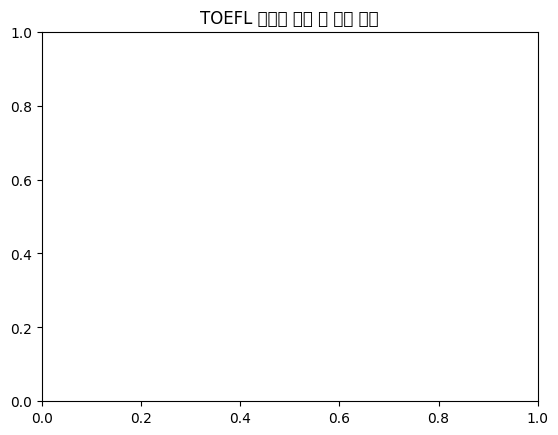

In [ ]:
# 타이틀 - TOEFL 이상치 제거 전 점수 분포
plt.title('TOEFL 이상치 제거 전 점수 분포')

# kdeplot 그래프
sns.kdeplot(x = train["Num_H_Acceptors"], color = "red")
sns.kdeplot(x = sigma_data["Num_H_Acceptors"], color = "blue")
sns.kdeplot(x = iqr15_data["Num_H_Acceptors"], color = "green")

# 그래프 출력
plt.show()

## 지금 아이디어 


## EDA 일부 해본 결과 이상치를 제거해서 한번 해보는 것이 좋지 않을까 생각중ㅇ이다. 이상치를 제가히면 더 좋지 않을까?? 

In [ ]:
train_data.head()

,ID,제품,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,B002-00002-00001,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,0,0,0,1,3,2,0,0,2,0
2,2,B002-00002-00002,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,B002-00002-00003,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,B002-00003-00001,B002-C001-0001,B002-C002-0001,B002-C003-0003,B002-00003,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


C:\Users\User\AppData\Local\Temp\ipykernel_36276\27430286.py:37: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_36276\27430286.py:37: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_36276\27430286.py:37: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_36276\27430286.py:37: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_36276\27430286.py:37: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_36276\27430286.py:37: UserWarning: Glyph 48652 (\N{HANGUL SYLLABLE BEU}) missing from current font.
  plt.tight_layout()
C:\Users\User\

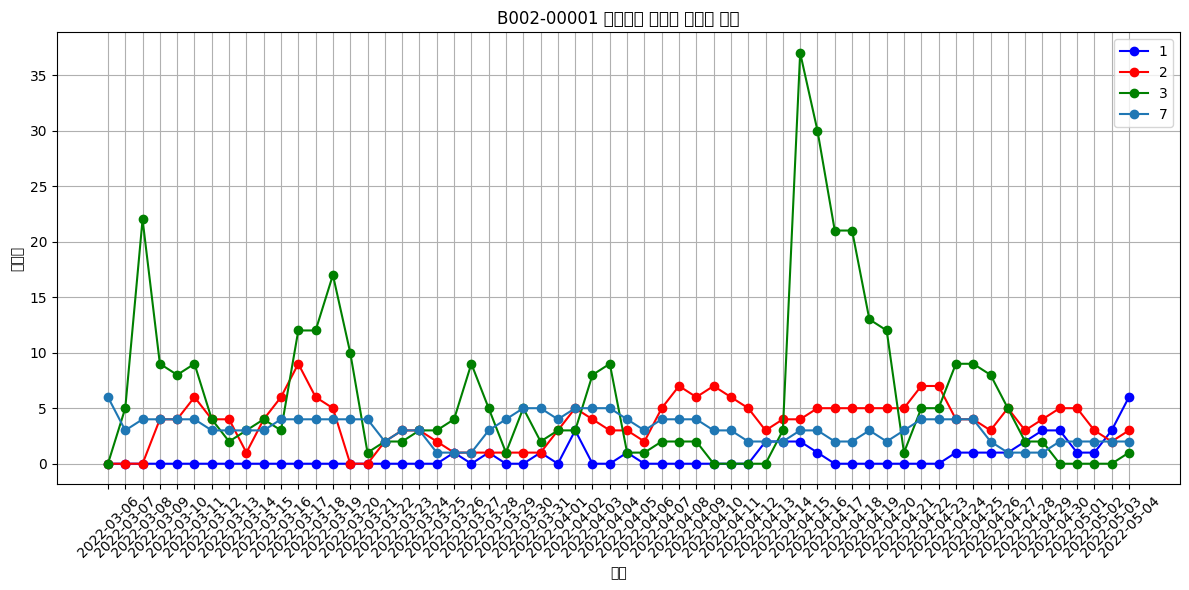

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 불러오기 (예: 데이터프레임 이름을 train_data로 가정)
# train_data = pd.read_csv('데이터 파일 경로.csv')

# 분석할 특정 브랜드명 지정
target_brand_1 = 'B002-00001'  # 분석하려는 브랜드명으로 변경
target_brand_2 = 'B002-00002'
target_brand_3 = 'B002-00003'
target_brand_4 = 'B002-00007'
# target_brand_3 = 'B002-00003'

# 해당 브랜드의 판매량 데이터 추출
brand_sales_1 = train_data[(train_data['브랜드'] == target_brand_1) & (train_data['대분류'] == 'B002-C001-0002')].iloc[:, 70: 130]
brand_sales_2 = train_data[train_data['브랜드'] == target_brand_2].iloc[:, 70: 130]  # 4번째 열부터 판매량 데이터가 시작됨
brand_sales_3 = train_data[train_data['브랜드'] == target_brand_3].iloc[:, 70: 130]
brand_sales_4 = train_data[train_data["브랜드"] == target_brand_4].iloc[:, 70: 130]


# 날짜를 인덱스로 설정 (datetime 형식이 아닌 경우 필요하면 날짜 형식으로 변환)
# brand_sales.columns = pd.to_datetime(brand_sales.columns)

# 판매량 변화 시각화
plt.figure(figsize=(12, 6))
plt.plot(brand_sales_1.columns, brand_sales_1.values[0], marker='o', linestyle='-', color = 'blue',label = "1")
plt.plot(brand_sales_2.columns, brand_sales_2.values[0], marker='o', linestyle='-', color =  'red', label = "2")
plt.plot(brand_sales_3.columns, brand_sales_3.values[0], marker='o', linestyle='-', color =  'green', label = "3")
plt.plot(brand_sales_4.columns, brand_sales_4.values[0], marker='o', linestyle='-', label = "7")

plt.title(f'{target_brand} 브랜드의 날짜별 판매량 변화')
plt.xlabel('날짜')
plt.ylabel('판매량')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
train_data.head()

,ID,제품,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,B002-00002-00001,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,0,0,0,1,3,2,0,0,2,0
2,2,B002-00002-00002,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,B002-00002-00003,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,B002-00003-00001,B002-C001-0001,B002-C002-0001,B002-C003-0003,B002-00003,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# import pandas as pd

# # 위에서 제공된 데이터를 불러옵니다.
# # train_data = pd.read_csv('your_train_data.csv')

# # 날짜 열 선택 (예시에서는 '2022-01-01'부터 '2023-04-04'까지의 열을 선택합니다.)
# date_columns = train_data.columns[6:]

# # 주기를 정의합니다. 1주일, 2주일, 3주일, 4주일, 한 달, 두 달
# periods = [3, 7, 14, 21, 28, 30, 60, 120,150 ]

# # 주기별 판매량을 계산하여 데이터 프레임에 추가합니다.
# for period in periods:
#     # 주기별 판매량을 계산합니다.
#     sales_sum = train_data[date_columns[-period:]].sum(axis=1)  # 주기별 합계 계산

#     # 열 이름을 생성합니다. (예: '1주일_판매량', '2주일_판매량', ...)
#     column_name = f'{period}주일_판매량'

#     # 데이터 프레임에 주기별 판매량 열을 추가합니다.
#     train_data[column_name] = sales_sum

# # 결과를 확인합니다.
# train_data.head()


,ID,제품,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,...,2023-04-04,7주일_판매량,14주일_판매량,21주일_판매량,28주일_판매량,30주일_판매량,60주일_판매량,3주일_판매량,120주일_판매량,150주일_판매량
0,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,0,0,0,0,...,0,594840,1189680,2373836,4736712,9451680,18860224,257976,37635055,75100230
1,1,B002-00002-00001,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,0,859965,1719937,3431880,6847904,13664356,27266332,372918,54408928,108572286
2,2,B002-00002-00002,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,0,92,184,368,736,1472,2944,46,5931,11852
3,3,B002-00002-00003,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,0,0,0,0,0,0,0,0,0,22
4,4,B002-00003-00001,B002-C001-0001,B002-C002-0001,B002-C003-0003,B002-00003,0,0,0,0,...,0,901255,1802510,3596652,7176700,14320456,28575598,390867,57021600,113786145


In [ ]:
# import pandas as pd

# # 위에서 제공된 데이터를 불러옵니다.
# # train_data = pd.read_csv('your_train_data.csv')

# # 날짜 열 선택 (예시에서는 '2022-01-01'부터 '2023-04-04'까지의 열을 선택합니다.)
# date_columns = train_data.columns[6:]

# # 주기를 정의합니다. 1주일, 2주일, 3주일, 4주일, 한 달, 두 달
# periods = [3, 7, 14, 21, 28, 30, 60, 120,150 ]

# # 주기별 판매량을 계산하여 데이터 프레임에 추가합니다.
# for period in periods:
#     # 주기별 판매량을 계산합니다.
#     sales_sum = train_data[date_columns[-period:]].sum(axis=1)  # 주기별 합계 계산

#     # 열 이름을 생성합니다. (예: '1주일_판매량', '2주일_판매량', ...)
#     column_name = f'{period}주일_판매량'

#     # 데이터 프레임에 주기별 판매량 열을 추가합니다.
#     train_data[column_name] = sales_sum

# # 결과를 확인합니다.
# train_data.head()


In [19]:
import pandas as pd

# 위에서 제공된 데이터를 불러옵니다.
# train_data = pd.read_csv('your_train_data.csv')

# 날짜 열 선택 (예시에서는 '2022-01-01'부터 '2023-04-04'까지의 열을 선택합니다.)
date_columns = train_data.columns[6:]

# 주기를 정의합니다. 1주일, 2주일, 3주일, 4주일, 한 달, 두 달
periods = [3, 7, 14, 21, 28, 30, 60, 120, 150]

# 브랜드 열 선택
brand_column = '브랜드'

# 결과를 저장할 데이터프레임 생성
result_df = pd.DataFrame()

# 브랜드별로 주기별 판매량을 계산하여 데이터프레임에 추가합니다.
for brand in train_data[brand_column].unique():
    # 브랜드별 데이터 추출
    brand_data = train_data[train_data[brand_column] == brand].copy()

    for period in periods:
        # 주기별 판매량을 계산합니다.
        sales_sum = brand_data[date_columns[-period:]].sum(axis=1)  # 주기별 합계 계산

        # 열 이름을 생성합니다. (예: '1주일_판매량', '2주일_판매량', ...)
        column_name = f'{period}주일_판매량'

        # 데이터프레임에 주기별 판매량 열을 추가합니다.
        brand_data[column_name] = sales_sum

    # 브랜드별 결과를 전체 결과 데이터프레임에 추가합니다.
    result_df = pd.concat([result_df, brand_data])

# 결과를 확인합니다.
result_df.head()


,ID,제품,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,...,2023-04-04,3주일_판매량,7주일_판매량,14주일_판매량,21주일_판매량,28주일_판매량,30주일_판매량,60주일_판매량,120주일_판매량,150주일_판매량
0,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,0,0,0,0,...,0,0,0,0,0,0,0,44,201,230
1,1,B002-00002-00001,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,0,2,8,8,8,8,8,27,66,66
2,2,B002-00002-00002,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,0,0,0,0,0,0,0,0,51,84
3,3,B002-00002-00003,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,0,0,0,0,0,0,0,0,0,29
4,4,B002-00003-00001,B002-C001-0001,B002-C002-0001,B002-C003-0003,B002-00003,0,0,0,0,...,0,0,0,0,0,0,0,66,197,584


In [22]:
result_df.tail()

,ID,제품,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,...,2023-04-04,3주일_판매량,7주일_판매량,14주일_판매량,21주일_판매량,28주일_판매량,30주일_판매량,60주일_판매량,120주일_판매량,150주일_판매량
15885,15885,B002-03799-00002,B002-C001-0003,B002-C002-0008,B002-C003-0042,B002-03799,0,0,0,0,...,0,0,0,0,0,0,0,454,1478,2623
15886,15886,B002-03799-00003,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03799,0,0,0,0,...,3,5,14,14,14,14,14,602,1104,1233
15887,15887,B002-03799-00004,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03799,0,0,0,0,...,0,0,0,0,0,0,0,3,13,42
15888,15888,B002-03799-00005,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03799,0,0,0,0,...,2,2,2,2,2,2,2,16,87,133
15889,15889,B002-03799-00010,B002-C001-0002,B002-C002-0004,B002-C003-0020,B002-03799,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
brand_keyword_cnt.head(2)

,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,B002-00001,0.84131,0.91383,1.45053,2.42239,1.87119,1.58108,1.23295,1.17493,1.14592,...,0.31911,0.39164,0.37713,0.49318,0.07252,0.29010,0.31911,0.23208,0.33362,0.44966
1,B002-00002,12.64868,20.27850,15.33217,12.75021,13.56251,13.70757,11.93791,15.56425,14.08471,...,10.26979,11.96692,10.64693,10.41485,10.48738,9.48651,9.28343,10.42935,11.15462,11.38671


### 데이터 전처리

In [27]:
import pandas as pd

# 더 작은 값을 추가하여 분모가 0인 경우 방지하는 상수 정의
EPSILON = 1e-8

numeric_cols = train_data.columns[4:]

# 칵 column의 min 및 max 계산
min_values = train_data[numeric_cols].min(axis=1)
max_values = train_data[numeric_cols].max(axis=1)

# 각 행의 범위(max-min)를 계산하고, 범위가 0인 경우 EPSILON 더해주기
ranges = max_values - min_values + EPSILON

# min-max scaling 수행
scaled_data = (train_data[numeric_cols].subtract(min_values, axis=0)).div(ranges, axis=0)

# 스케일링된 데이터로 업데이트
train_data[numeric_cols] = scaled_data

# max와 min 값을 dictionary 형태로 저장
scale_min_dict = min_values.to_dict()
scale_max_dict = max_values.to_dict()


TypeError: '<=' not supported between instances of 'str' and 'int'

In [ ]:
# Label Encoding
label_encoder = LabelEncoder()
categorical_columns = ['대분류', '중분류', '소분류', '브랜드']

for col in categorical_columns:
    label_encoder.fit(train_data[col])
    train_data[col] = label_encoder.transform(train_data[col])

In [ ]:
def make_train_data(data, train_size=CFG['TRAIN_WINDOW_SIZE'], predict_size=CFG['PREDICT_SIZE']):
    '''
    학습 기간 블럭, 예측 기간 블럭의 세트로 데이터를 생성
    data : 일별 판매량
    train_size : 학습에 활용할 기간
    predict_size : 추론할 기간
    '''
    num_rows = len(data)
    window_size = train_size + predict_size
    
    input_data = np.empty((num_rows * (len(data.columns) - window_size + 1), train_size, len(data.iloc[0, :4]) + 1))
    target_data = np.empty((num_rows * (len(data.columns) - window_size + 1), predict_size))
    
    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :4])
        sales_data = np.array(data.iloc[i, 4:])
        
        for j in range(len(sales_data) - window_size + 1):
            window = sales_data[j : j + window_size]
            temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
            input_data[i * (len(data.columns) - window_size + 1) + j] = temp_data
            target_data[i * (len(data.columns) - window_size + 1) + j] = window[train_size:]
    
    return input_data, target_data

In [ ]:
def make_predict_data(data, train_size=CFG['TRAIN_WINDOW_SIZE']):
    '''
    평가 데이터(Test Dataset)를 추론하기 위한 Input 데이터를 생성
    data : 일별 판매량
    train_size : 추론을 위해 필요한 일별 판매량 기간 (= 학습에 활용할 기간)
    '''
    num_rows = len(data)
    
    input_data = np.empty((num_rows, train_size, len(data.iloc[0, :4]) + 1))
    
    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :4])
        sales_data = np.array(data.iloc[i, -train_size:])
        
        window = sales_data[-train_size : ]
        temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
        input_data[i] = temp_data
    
    return input_data

In [21]:
train_data.tail()

,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
15885,2,7,41,3169,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.000000
15886,2,7,43,3169,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.02439,0.0,0.01626,0.03252,0.00813,0.00813,0.024390
15887,2,7,43,3169,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.000000
15888,2,7,43,3169,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.142857
15889,1,3,19,3169,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.000000


In [22]:
train_input, train_target = make_train_data(train_data)
test_input = make_predict_data(train_data)

  0%|          | 0/15890 [00:00<?, ?it/s]

100%|██████████| 15890/15890 [00:19<00:00, 834.08it/s]


In [23]:
data_len = len(train_input)
val_ratio = 0.1
test_ratio = 0.1

val_len = int(data_len * val_ratio)
test_len = int(data_len * test_ratio)

val_input = train_input[-val_len:]
val_target = train_target[-val_len:]

train_input = train_input[:-val_len - test_len]
train_target = train_target[:-val_len - test_len]


In [25]:
train_input.shape, train_target.shape, val_input.shape, val_target.shape, test_input.shape

((4105976, 120, 5),
 (4105976, 21),
 (513247, 120, 5),
 (513247, 21),
 (15890, 120, 5))

### Custom Dataset

In [26]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.Y[index])
        return torch.Tensor(self.X[index])
    
    def __len__(self):
        return len(self.X)

In [27]:
train_dataset = CustomDataset(train_input, train_target)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset = CustomDataset(val_input, val_target)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

### 모델 선언

# Layer Normalization

In [32]:
class ImprovedModel(nn.Module):
    def __init__(self, input_size=5, hidden_size=512, num_layers=2, output_size=CFG['PREDICT_SIZE'], dropout_prob=0.2):
        super(ImprovedModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.ln = nn.LayerNorm(hidden_size)  # Layer Normalization
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, output_size)
        )
        self.actv = nn.ReLU()

    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size, x.device)

        gru_out, hidden = self.gru(x, hidden)
        gru_out = self.dropout(gru_out)
        gru_out = self.ln(gru_out)  # Applying Layer Normalization

        last_output = gru_out[:, -1, :]

        output = self.actv(self.fc(last_output))

        return output.squeeze(1)
    def init_hidden(self, batch_size, device):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)



### 모델 학습

In [34]:
def train(model, optimizer, train_loader, val_loader, device, scheduler=None):
    model.to(device)
    criterion = nn.MSELoss().to(device)
    best_loss = float('inf')
    best_model = None
    early_stopping_counter = 0
    max_early_stopping = 10  # Max number of consecutive epochs with increasing validation loss
    
    for epoch in range(1, CFG['EPOCHS'] + 1):
        model.train()
        train_loss = []
        train_mae = []

        for X, Y in tqdm(iter(train_loader)):
            X = X.to(device)
            Y = Y.to(device)

            optimizer.zero_grad()

            output = model(X)
            loss = criterion(output, Y)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())


        
        val_loss = validation(model, val_loader, criterion, device)
        print(f'Epoch : [{epoch}] Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}]')

        if scheduler is not None:
            scheduler.step(val_loss)  # Update learning rate based on scheduler's policy
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= max_early_stopping:
                print(f'Early stopping triggered at epoch {epoch}')
                break

    return best_model


In [36]:
def validation(model, val_loader, criterion, device):
    model.eval()
    val_loss = []
    
    with torch.no_grad():
        for X, Y in tqdm(iter(val_loader)):
            X = X.to(device)
            Y = Y.to(device)
            
            output = model(X)
            loss = criterion(output, Y)
            
            val_loss.append(loss.item())
    return np.mean(val_loss)

## Run !!

In [37]:
import torch.optim.lr_scheduler as lr_scheduler

model = ImprovedModel() # BaseModel() 
optimizer = torch.optim.RAdam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=1, factor=0.7, verbose=True)
infer_model = train(model, optimizer, train_loader, val_loader, device, scheduler)


100%|██████████| 126/126 [00:28<00:00,  4.44it/s]


Epoch : [1] Train Loss : [0.03244] Val Loss : [0.02965]


100%|██████████| 126/126 [00:28<00:00,  4.43it/s]


Epoch : [2] Train Loss : [0.03041] Val Loss : [0.03081]


100%|██████████| 126/126 [00:28<00:00,  4.49it/s]


Epoch : [3] Train Loss : [0.02909] Val Loss : [0.02969]
Epoch 00003: reducing learning rate of group 0 to 7.0000e-05.


100%|██████████| 126/126 [00:28<00:00,  4.48it/s]


Epoch : [4] Train Loss : [0.02816] Val Loss : [0.02954]


100%|██████████| 126/126 [00:28<00:00,  4.48it/s]


Epoch : [5] Train Loss : [0.02770] Val Loss : [0.03008]


100%|██████████| 126/126 [00:27<00:00,  4.50it/s]


Epoch : [6] Train Loss : [0.02476] Val Loss : [0.01791]


100%|██████████| 126/126 [00:27<00:00,  4.52it/s]


Epoch : [7] Train Loss : [0.01737] Val Loss : [0.01757]


100%|██████████| 126/126 [00:27<00:00,  4.64it/s]


Epoch : [8] Train Loss : [0.01701] Val Loss : [0.01704]


100%|██████████| 126/126 [00:27<00:00,  4.60it/s]


Epoch : [9] Train Loss : [0.01697] Val Loss : [0.01661]


100%|██████████| 126/126 [00:27<00:00,  4.61it/s]


Epoch : [10] Train Loss : [0.01682] Val Loss : [0.01810]


100%|██████████| 126/126 [00:27<00:00,  4.64it/s]


Epoch : [11] Train Loss : [0.01676] Val Loss : [0.01643]


100%|██████████| 126/126 [00:27<00:00,  4.59it/s]


Epoch : [12] Train Loss : [0.01646] Val Loss : [0.01679]


100%|██████████| 126/126 [00:27<00:00,  4.59it/s]


Epoch : [13] Train Loss : [0.01638] Val Loss : [0.01614]


100%|██████████| 126/126 [00:27<00:00,  4.60it/s]


Epoch : [14] Train Loss : [0.01637] Val Loss : [0.01640]


100%|██████████| 126/126 [00:27<00:00,  4.62it/s]


Epoch : [15] Train Loss : [0.01632] Val Loss : [0.01612]


100%|██████████| 126/126 [00:27<00:00,  4.56it/s]


Epoch : [16] Train Loss : [0.01625] Val Loss : [0.01610]


100%|██████████| 126/126 [00:27<00:00,  4.59it/s]


Epoch : [17] Train Loss : [0.01623] Val Loss : [0.01657]


100%|██████████| 126/126 [00:27<00:00,  4.60it/s]


Epoch : [18] Train Loss : [0.01619] Val Loss : [0.01629]
Epoch 00018: reducing learning rate of group 0 to 4.9000e-05.


100%|██████████| 126/126 [00:28<00:00,  4.45it/s]


Epoch : [19] Train Loss : [0.01606] Val Loss : [0.01621]


100%|██████████| 126/126 [00:27<00:00,  4.65it/s]


Epoch : [20] Train Loss : [0.01611] Val Loss : [0.01696]
Epoch 00020: reducing learning rate of group 0 to 3.4300e-05.


100%|██████████| 126/126 [00:28<00:00,  4.45it/s]


Epoch : [21] Train Loss : [0.01606] Val Loss : [0.01616]


100%|██████████| 126/126 [00:28<00:00,  4.46it/s]


Epoch : [22] Train Loss : [0.01594] Val Loss : [0.01603]


100%|██████████| 126/126 [00:28<00:00,  4.49it/s]


Epoch : [23] Train Loss : [0.01589] Val Loss : [0.01607]


100%|██████████| 126/126 [00:28<00:00,  4.44it/s]


Epoch : [24] Train Loss : [0.01584] Val Loss : [0.01611]
Epoch 00024: reducing learning rate of group 0 to 2.4010e-05.


100%|██████████| 126/126 [00:28<00:00,  4.48it/s]


Epoch : [25] Train Loss : [0.01577] Val Loss : [0.01617]


100%|██████████| 126/126 [00:27<00:00,  4.63it/s]


Epoch : [26] Train Loss : [0.01573] Val Loss : [0.01616]
Epoch 00026: reducing learning rate of group 0 to 1.6807e-05.


100%|██████████| 126/126 [00:26<00:00,  4.68it/s]


Epoch : [27] Train Loss : [0.01568] Val Loss : [0.01624]


100%|██████████| 126/126 [00:27<00:00,  4.63it/s]


Epoch : [28] Train Loss : [0.01565] Val Loss : [0.01631]
Epoch 00028: reducing learning rate of group 0 to 1.1765e-05.


100%|██████████| 126/126 [00:28<00:00,  4.43it/s]


Epoch : [29] Train Loss : [0.01561] Val Loss : [0.01640]


100%|██████████| 126/126 [00:28<00:00,  4.48it/s]


Epoch : [30] Train Loss : [0.01559] Val Loss : [0.01642]
Epoch 00030: reducing learning rate of group 0 to 8.2354e-06.


100%|██████████| 126/126 [00:28<00:00,  4.49it/s]


Epoch : [31] Train Loss : [0.01555] Val Loss : [0.01637]


100%|██████████| 126/126 [00:28<00:00,  4.47it/s]

Epoch : [32] Train Loss : [0.01554] Val Loss : [0.01670]
Epoch 00032: reducing learning rate of group 0 to 5.7648e-06.
Early stopping triggered at epoch 32


## 모델 추론

In [38]:
test_dataset = CustomDataset(test_input, None)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [39]:
def inference(model, test_loader, device):
    predictions = []
    
    with torch.no_grad():
        for X in tqdm(iter(test_loader)):
            X = X.to(device)
            
            output = model(X)
            
            # 모델 출력인 output을 CPU로 이동하고 numpy 배열로 변환
            output = output.cpu().numpy()
            
            predictions.extend(output)
    
    return np.array(predictions)

In [40]:
pred = inference(infer_model, test_loader, device)

100%|██████████| 4/4 [00:00<00:00,  6.07it/s]


In [41]:
# 추론 결과를 inverse scaling
for idx in range(len(pred)):
    pred[idx, :] = pred[idx, :] * (scale_max_dict[idx] - scale_min_dict[idx]) + scale_min_dict[idx]
    
# 결과 후처리
pred = np.round(pred, 0).astype(int)

In [42]:
pred.shape

(15890, 21)

## Submission

In [52]:
submit = pd.read_csv('E:/LG/LG_data/sample_submission.csv')
submit.tail()

,ID,2023-04-05,2023-04-06,2023-04-07,2023-04-08,2023-04-09,2023-04-10,2023-04-11,2023-04-12,2023-04-13,...,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,2023-04-25
15885,15885,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15886,15886,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15887,15887,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15888,15888,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15889,15889,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
submit.iloc[:,1:] = pred
submit.head()

,ID,2023-04-05,2023-04-06,2023-04-07,2023-04-08,2023-04-09,2023-04-10,2023-04-11,2023-04-12,2023-04-13,...,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,2023-04-25
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,0,1,1
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,1
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
submit.to_csv('E:/LG/LG_data/models/baseline_submit_epoch_23_130_4096_512_RAdam_GRUNOnozition_2_LAYER_2_774999489560.3.csv', index=False)